# VECM Estimations: Recursive Algorithm

### *Leonardo Caio de Ladalardo Martins*
lcladalardo@gmail.com

_*Undergraduate student at FEA-USP_

In [69]:
%matplotlib inline

In [70]:
#Starting with usual imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import matplotlib.ticker as mtick
from matplotlib import gridspec

# Recursive Estimation Algorithm

The recursive estimation algorithm has been written using as basis the [StatsModel package](https://www.statsmodels.org/stable/index.html). As we're focusing on VECM estimations, so this algorithm will be based mainly on a VECM model. However, it could be easily adapted to any other class of econometric models. 
Basics: the algorithm consists in a class of 'methods' that are applied to a particular object. This class has many 'methods', such as a basic VEC estimation and a Recursive Estimation structure.

The main requirements of the algorithm is:
1. The data needs to be displayed on a time series format, and the date column must be writen as `'yyyy'm'mm'` (e.g. 1968m12 or 1978m7)
2. It must be performed all the initial tests before running the VECM model, i.e. it must be checked the existence of cointegration using Johansen Cointegration Test or Engle-Granger tests; 

Parameters of the recursive estimation:
- `initial_date`: the first period of estimation;
- `start_date`: the first period of recursive estimation;
- `end_date`: last period of recursive estimation;
- `endog`: endogenous variables of VECM;
- `exog`: exogenous variables out of the cointegration equation (if `exog = 0`, so the estimation doesn't have any exogenous variables outside the cointegration equation) 
- `exog_coint`: exogenous variables in the cointegration equation (if `exog_coint = 0`, so the estimation doesn't have any exogenous variables inside the cointegration equation);
- `coef_of_interest`: positioning of the coefficient of interest (e.g. if we're interested in beta 1, so the `coef_of_interest` would be 1.)

What the Recursive function will return? A dataframe time indexed with the following attributes:
- The coefficient of interest;
- The standard deviation of the coefficient in interest;
- It's lower and upper confidence interval thresholds;
- The number of vector of cointegration after applying the maximum eigenvalue and trace of the Johansen test;

We've also developed a graph function to plot all these variables of interest in one single plot, helping to visualize what is happening with the coefficients while we add observations and estimate it recursively.

In [57]:
import statsmodels.api as sm
from statsmodels.tsa.api import VECM
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.vector_ar.vecm import select_order
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.vector_ar.vecm import VECMResults
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from statsmodels.tsa.vector_ar.var_model import LagOrderResults

In [72]:
class estimation:
    
    #Iniatilizing de algorithm
    def __init__(self,path):
        self.data = pd.read_csv(path)
    #Reading the basic dataset    
    
    def dataset(self):
        return self.data
    
    #Estimating a VEC model, based on a given start and end date
    def vecm(self, initial_date, end_date, date, endog, exog, exog_coint):
        self.start = date.index.get_loc(date.index[date == initial_date][0])
        self.end =  date.index.get_loc(date.index[date == end_date][0])
        self.date = dates_from_str(date.iloc[self.start:self.end])
        self.endog = endog.iloc[self.start:self.end,:]
        if exog_coint.size == 0:
            self.exog_coint = None
        else:
            self.exog_coint = exog_coint.iloc[self.start:self.end,:]
        if exog == 0:
            self.exog = None
        else:
            self.exog_coint = exog_coint.iloc[self.start:self.end,:]
        self.model = VECM(endog = self.endog, exog_coint = self.exog, dates = self.date, 
                           freq=None, k_ar_diff=12, coint_rank=1, deterministic='nc', seasons=12, first_season=0).fit()
        return self.model
    
    #Defining the Recursive Estimation function
    def rec_est(self,initial_date, start_date, end_date, date, endog, exog, exog_coint, coef_of_interest):
        self.initial = date.index.get_loc(date.index[date == initial_date][0])
        self.start = date.index.get_loc(date.index[date == start_date][0])
        self.end =  date.index.get_loc(date.index[date == end_date][0])
        self.n = self.end - self.start
        for i in range(1,self.n+1):
            self.date = dates_from_str(date.iloc[self.start:self.end])
            self.endog = endog.iloc[self.initial:self.start+i,:]
            if exog_coint.size == 0:
                self.exog_coint = None
            else:
                self.exog_coint = exog_coint.iloc[self.initial:self.start+i,:]
            if exog == 0:
                self.exog = None
            else:
                self.exog_coint = exog_coint.iloc[11:self.start+i,:]
            self.modelo = VECM(endog=self.endog,exog = self.exog, exog_coint=self.exog, dates=self.date, 
                               freq='M', missing='none', k_ar_diff=12, coint_rank=1, 
                               deterministic='nc', seasons=12, first_season=0)
            self.vecm = self.modelo.fit()
            self.beta = self.vecm.beta
            self.ic = self.vecm.conf_int_beta(0.1)
            self.std = self.vecm.stderr_beta
            self.df_ic = pd.DataFrame(self.ic[1])
            self.coint_eig = select_coint_rank(self.endog, -1, k_ar_diff=12, method='maxeig', signif=0.05)
            self.coint_trace = select_coint_rank(self.endog, -1, k_ar_diff=12, method='trace', signif=0.05)
            if i ==1:
                self.BETA = self.beta
                self.STD = self.std
                self.IC = self.df_ic
                self.eig = [self.coint_eig.rank] 
                self.trace = [self.coint_trace.rank]
            else:
                self.BETA = np.concatenate((self.BETA, self.beta), axis=1)
                self.STD = np.concatenate((self.STD, self.std), axis=1)
                self.IC = self.IC.append(self.df_ic)
                self.eig.append(self.coint_eig.rank)
                self.trace.append(self.coint_trace.rank)
        self.periods = dates_from_str(self.data['data'].iloc[self.start:self.end])
        self.data = {'Periods': self.periods, 'Coeficients': self.BETA[coef_of_interest], 
                     'Coeficients Std.': self.STD[coef_of_interest],
                      'Max_eig_vectors': self.eig, 'Trace_vectors':self.trace, 
                      'lower_ci_level': self.IC['lower'], 'upper_ci_level': self.IC['upper']}
        self.df = pd.DataFrame(self.data)
        return self.df

### Example: Pass-Through Estimation

We're going to apply those functions to a dataset used to write my final undergraduate thesis at Universidade de São Paulo. This dataset consists in observations of domestic inflation levels, exchange rate, gdp gap, a proxy of the oppenness of the economy and external inflation rates. All the variables has monthly observations, starting from 1998m1 to 2019m6.

In [73]:
#Providing the path of the csv file
path = 'F:/Python Files/6 - Monografia/Base de dados.csv'

In [74]:
#Initializing the algorithm
model = estimation(path)

In [75]:
#Loading the dataset used on the estimation
df = model.dataset()

In [76]:
df.head()

,data,LN_IGPM,LN_IPCA,LN_ABER,LN_HIATO,LN_PIB,LN_DOLAR,LN_CPI,LN_PPI,D1,...,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12
0,1998m1,4.605170,4.605170,4.605170,4.605170,4.605170,4.605170,4.605170,4.605170,1,...,0,0,0,0,0,0,0,0,0,0
1,1998m2,4.606969,4.609760,4.540909,4.551718,4.559596,4.617426,4.607025,4.601975,0,...,0,0,0,0,0,0,0,0,0,0
2,1998m3,4.608867,4.613154,4.690716,4.605522,4.619492,4.617426,4.608876,4.599572,0,...,1,0,0,0,0,0,0,0,0,0
3,1998m4,4.610166,4.615551,4.657085,4.606161,4.627624,4.624024,4.610724,4.601175,0,...,0,1,0,0,0,0,0,0,0,0
4,1998m5,4.611565,4.620539,4.623984,4.646406,4.676216,4.630057,4.612568,4.602775,0,...,0,0,1,0,0,0,0,0,0,0


In [77]:
#Defining the data to be used on the estimation:
date = df['data']
endog = df[['LN_IGPM', 'LN_HIATO', 'LN_DOLAR']]
exog_coint = df[['LN_CPI', 'LN_PPI', 'LN_ABER']]
exog = 0

#### Estimation for a particular sub-sample 

In [78]:
#Estimating a vecm model starting from the 2010m1 to 2018m12 sample
estimation = model.vecm('2010m1', '2018m12', date, endog, exog, exog_coint)

C:\Users\lelec\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [79]:
#Providing the estimation output
estimation.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
season1,-7.133e-05,0.004,-0.017,0.987,-0.009,0.008
season2,-0.0042,0.005,-0.786,0.432,-0.015,0.006
season3,0.0104,0.005,2.231,0.026,0.001,0.019
season4,-0.0027,0.004,-0.677,0.498,-0.011,0.005
season5,-0.0055,0.004,-1.348,0.178,-0.014,0.003
season6,-0.0004,0.005,-0.089,0.929,-0.010,0.009
season7,-0.0016,0.004,-0.410,0.682,-0.009,0.006
season8,0.0026,0.003,0.763,0.446,-0.004,0.009
season9,-0.0048,0.004,-1.153,0.249,-0.013,0.003
season10,-0.0004,0.005,-0.092,0.927,-0.010,0.009


#### Recursive Estimation 

In [80]:
#Recursive estimation from 1999m1 adding periods recursively starting from 2010m1 until 2018m12 to the beta1 parameter
rec_estimation = model.rec_est('1999m1',  '2010m1', '2018m12', date, endog, exog, exog_coint, 1)

In [81]:
rec_estimation

,Periods,Coeficients,Coeficients Std.,Max_eig_vectors,Trace_vectors,lower_ci_level,upper_ci_level
0,2010-01-31,-0.948087,0.584392,0,0,-1.909326,0.013152
0,2010-02-28,-0.900205,0.643816,0,1,-1.959189,0.158778
0,2010-03-31,-0.783660,0.621262,0,0,-1.805545,0.238225
0,2010-04-30,-0.741530,0.599581,0,0,-1.727752,0.244693
0,2010-05-31,-0.764923,0.600254,0,0,-1.752253,0.222407
0,2010-06-30,-0.674264,0.556495,0,0,-1.589617,0.241089
0,2010-07-31,-0.661240,0.541222,0,0,-1.551472,0.228992
0,2010-08-31,-0.626549,0.545918,0,0,-1.524505,0.271406
0,2010-09-30,-0.643758,0.558036,0,0,-1.561646,0.274130
0,2010-10-31,-0.659475,0.556404,0,0,-1.574678,0.255728


Creating a function to plot some information of interest:

In [84]:
def recursive_plot(df_new,date, name, loc):
    fig = plt.figure(figsize=(18,6))
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1]) 
    
    # First subplot:
    ax1 = plt.subplot(gs[0])
    df_new['Coeficientes_6m_avg'] = df_new['Coeficients'].rolling(window=6, center = True).mean()
    plt.grid(color='black', linestyle='-.', linewidth=.2)
    plt.plot(df_new['Periods'],-df_new['Coeficientes_6m_avg'], color = 'red', 
             label = '6-month average of the recursive estimation')
    plt.plot(df_new['Periods'],-df_new['Coeficients'], color = 'blue', linestyle = '--',
             label = 'Recursive estimation coefficients')
    plt.fill_between(df_new['Periods'],-df_new['lower_ci_level'],-df_new['upper_ci_level'], 
                     color = 'dodgerblue', alpha=0.2, label='Confidence interval of the recusive estimations')
    plt.xlim([date, '2018-12-01'])
    plt.legend(loc=loc,prop={'size': 12}, framealpha = 0)
    
    # Second subplot:
    ax2 = plt.subplot(gs[1], sharex = ax1)
    fig.subplots_adjust(hspace=0)
    ax2.set_yticklabels([])
    ax2.twinx()
    plt.plot(df_new['Periods'],df_new['Max_eig_vectors'], color = 'green',
             linestyle = '--', label = 'Trace # of vectors')
    plt.plot(df_new['Periods'],df_new['Trace_vectors'], color = 'mediumblue',
             linestyle = '--', label = 'Maximum Eingenvalue # of vectors')
    plt.legend(loc=loc+1,prop={'size': 12}, framealpha = 0)
    plt.savefig(name + '.png')
    plt.show()

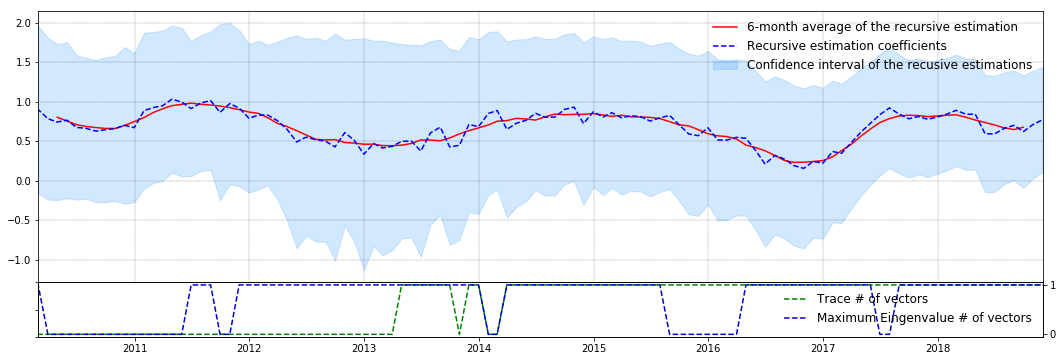

In [85]:
recursive_plot(rec_estimation, '2010-03-01', 'IGPM_REC',0)